# IT Service Ticket Classification

## Navegação dos notebooks

- `notebooks/analysis.ipynb`: análise exploratória (EDA).
- `notebooks/classificators.ipynb`: testes de classificadores (TF-IDF, embeddings, RAG) com métricas no conjunto de teste.
- `notebooks/main.ipynb`: visão geral, prompts, pipeline, avaliação final (usa o classificador escolhido).


## 1. Carregamento e Preparação dos Dados

### Divisão em treino, teste e validação

Usamos três conjuntos de dados:

1. **Validação (balanceada)**: `VALIDATION_SIZE` tickets, com o mesmo número de exemplos por classe.
2. **Treino/Teste**: o restante é dividido em **80% treino** e **20% teste**, com estratificação.

**Por que assim?**
- **Validação balanceada** garante comparação justa entre classes.
- **Teste separado** permite comparar métodos antes da avaliação final.
- **Treino maior** melhora a qualidade dos modelos.


In [1]:
from classifier.data import load_dataset, train_test_validation_split

# Carregar dataset
df, classes = load_dataset()
print(f"Total de tickets: {len(df):,}")
df.head()

Total de tickets: 47,837


,Document,Topic_group
0,connection with icon icon dear please setup ic...,Hardware
1,work experience user work experience user hi w...,Access
2,requesting for meeting requesting meeting hi p...,Hardware
3,reset passwords for external accounts re expir...,Access
4,mail verification warning hi has got attached ...,Miscellaneous


In [2]:
# Classes obtidas do dataset
print(f"Classes ({len(classes)}):")
for c in classes:
    print(f"  - {c}")

Classes (8):
  - Access
  - Administrative rights
  - HR Support
  - Hardware
  - Internal Project
  - Miscellaneous
  - Purchase
  - Storage


In [3]:
from classifier.config import VALIDATION_SIZE

# Split: validação balanceada + treino/teste estratificados (80/20)
train_df, test_df, validation_df = train_test_validation_split(
    df,
    validation_size=VALIDATION_SIZE,
)

print(f"Treino:     {len(train_df):,} tickets")
print(f"Teste:      {len(test_df):,} tickets")
print(f"Validação:  {len(validation_df):,} tickets")
print("\nDistribuição na validação:")
print(validation_df["Topic_group"].value_counts().sort_index())

Treino:     38,109 tickets
Teste:      9,528 tickets
Validação:  200 tickets

Distribuição na validação:
Topic_group
Access                   25
Administrative rights    25
HR Support               25
Hardware                 25
Internal Project         25
Miscellaneous            25
Purchase                 25
Storage                  25
Name: count, dtype: int64


## 2. Métodos de Classificação e Comparação

Os experimentos de classificação estão em `notebooks/classificators.ipynb`, onde rodamos TF-IDF, embeddings e RAG no conjunto de teste.

Modelo selecionado (teste):
- **TF-IDF + LinearSVC** — accuracy **0.8637**, F1 macro **0.8641**, F1 weighted **0.8639**.

As seções seguintes assumem este modelo como escolhido.


## 3. Geração da Justificativa

Implementamos **dois métodos** de geração de justificativa para a classe predita:

### 3.1 Justificativa Linear (padrão)

- Usa os **pesos do classificador linear** (TF-IDF + LinearSVC) para selecionar os 2–4 n-grams com maior contribuição para a classe predita.
- É **determinística**, rápida e não depende de LLM (ideal para execução local e reprodutível).
- Compartilha o **mesmo extrator de features TF-IDF** usado no treinamento do classificador, garantindo consistência entre decisão e justificativa.

### 3.2 Justificativa com LLM + RAG (opcional)

Quando queremos uma justificativa mais “natural”, usamos uma LLM para redigir 1–3 frases em PT-BR, condicionada à classe predita e a exemplos recuperados via RAG.

#### 3.2.1 Design dos Prompts

O prompt é dividido em duas partes:

1. **System prompt:** define o papel da LLM (gerar justificativas) e o formato de saída em JSON.
2. **User prompt:** inclui o ticket, a **classe atribuída** (saída do ML) e os **tickets similares** recuperados pelo RAG como evidência.

**Por que usar RAG aqui?**
- A LLM não decide a classe; ela só explica uma decisão já tomada.
- Tickets similares fornecem evidência (“casos parecidos na mesma classe”), fortalecendo a justificativa.

**Trade-off do número de similares (K):**
- **Mais similares:** justificativas mais ricas, porém maior custo em tokens.
- **Menos similares:** justificativas mais baratas, porém com menos evidência.


### 3.1 Justificativa Linear (padrão)

- Usa os **pesos do classificador linear** (TF-IDF + LinearSVC) para selecionar os 2–4 n-grams com maior contribuição para a classe predita.
- É **determinística**, rápida e não depende de LLM (ideal para execução local e reprodutível).

In [4]:
from classifier.classifiers import TfidfClassifier
from classifier.config import RANDOM_STATE

# Treinar classificador base para exemplos de justificativa
ml_classifier = TfidfClassifier.linear_svc(random_state=RANDOM_STATE)
ml_classifier.fit(train_df)
features = ml_classifier.features

# Selecionar um ticket da validação como exemplo
sample = validation_df.sample(1, random_state=RANDOM_STATE).iloc[0]
query = sample["Document"]
true_class = sample["Topic_group"]
predicted_class = ml_classifier.predict([query])[0]

In [5]:
from classifier.justifiers import LinearJustifier

linear_justifier = LinearJustifier(
    ml_classifier.classifier.coef_,
    ml_classifier.classifier.classes_,
    features,
)
details_linear = linear_justifier.justify(
    ticket=query,
    predicted_class=predicted_class,
)

print(f'Classe real: {true_class}')
print(f'Classe predita (ML): {predicted_class}')
print(f'Justificativa (linear): {details_linear.result.justificativa}')
print(f'Termos de evidência: {details_linear.evidence_terms}')

Classe real: HR Support
Classe predita (ML): HR Support
Justificativa (linear): O ticket foi classificado como 'HR Support' por mencionar 'annual', 'leave', 'annual leave', 'balance', que são termos comumente associados a essa categoria.
Termos de evidência: ['annual', 'leave', 'annual leave', 'balance']


### 3.2 Justificativa com LLM + RAG (opcional)

Quando queremos uma justificativa mais “natural”, usamos uma LLM para redigir 1–3 frases, condicionada à classe predita e a exemplos recuperados via RAG.

#### 3.2.1 Design dos Prompts

O prompt é dividido em duas partes:

1. **System prompt:** define o papel da LLM (gerar justificativas) e o formato de saída em JSON.
2. **User prompt:** inclui o ticket, a **classe atribuída** (saída do ML) e os **tickets similares** recuperados pelo RAG como evidência.

**Por que usar RAG aqui?**
- A LLM não decide a classe; ela só explica uma decisão já tomada.
- Tickets similares fornecem evidência (“casos parecidos na mesma classe”), fortalecendo a justificativa.

**Trade-off do número de similares (K):**
- **Mais similares:** justificativas mais ricas, porém maior custo em tokens.
- **Menos similares:** justificativas mais baratas, porém com menos evidência.


In [6]:
from classifier.llm import build_system_prompt, build_user_prompt
from classifier.rag import TicketRetriever

from classifier.config import EMBEDDING_MODEL, K_SIMILAR


# Indexar dados de treino para recuperar tickets similares (RAG)
retriever = TicketRetriever(EMBEDDING_MODEL)
retriever.index(train_df)

# Para comparação de tokens, buscamos um K maior
max_k = max(K_SIMILAR, 10)
similar = retriever.retrieve(query, k=max_k)

Batches:   0%|          | 0/1191 [00:00<?, ?it/s]

In [7]:
# Exemplo 1: System Prompt
system_prompt = build_system_prompt()
print("=== SYSTEM PROMPT ===\n")
print(system_prompt)

=== SYSTEM PROMPT ===

Você é um assistente que gera justificativas para classificações de tickets de suporte de TI.

Responda APENAS com JSON no formato:
{"justificativa": "<explicação curta e objetiva de 1-3 frases>"}

A justificativa deve ser escrita em **Português (Brasil)**.
Use evidências do ticket e dos exemplos fornecidos para sustentar a classe informada.
Não mencione tickets similares explicitamente (ex.: “ticket 2”).

Regras:
- A justificativa deve ser auto contida.
- Não mencione tickets similares explicitamente (ex.: “ticket 2”).
- Use apenas evidências gerais do conteúdo do ticket.
- Cite explicitamente de 2 a 4 termos literais do ticket entre aspas simples (ex.: 'vpn', 'password', 'oracle').

Responda APENAS com JSON no formato:
{{"justificativa": "<explicação curta e objetiva de 1-3 frases>"}}


In [8]:
# Exemplo 2: User Prompt (K=5 similares)
user_prompt = build_user_prompt(query, predicted_class, similar[:5])
print("=== USER PROMPT ===\n")
print(user_prompt)

=== USER PROMPT ===

Gere uma justificativa para a classificação abaixo.

**Classe atribuída:** HR Support

**Ticket:**
annual leave balance thursday pm annual leave balance hi please think update holiday st july cancelled thanks coordinator ext

## Tickets Similares (como evidência)
1. [HR Support] annual leave incorrect balance sent monday july balance holidays hi balance holidays correct below told you able change could you please let know if correct can send you details thanks manager re balance holidays hi holiday configuration still work progress why might seem being incorrect but should you spot anything please raise ticket thanks manager sent monday july balance holidays hi can change balance holidays if correct set regards
2. [HR Support] missing leave day july pm leave hello checked annual leave balance noticed out days left taken days annual leave had please out thank
3. [HR Support] annual leave on th and th of july wednesday pm holiday hello had booked annual leave july sa

In [9]:
# Exemplo 3: User Prompt (K=3 similares)
user_prompt_k3 = build_user_prompt(query, predicted_class, similar[:3])
print("=== USER PROMPT (K=3) ===\n")
print(user_prompt_k3)

=== USER PROMPT (K=3) ===

Gere uma justificativa para a classificação abaixo.

**Classe atribuída:** HR Support

**Ticket:**
annual leave balance thursday pm annual leave balance hi please think update holiday st july cancelled thanks coordinator ext

## Tickets Similares (como evidência)
1. [HR Support] annual leave incorrect balance sent monday july balance holidays hi balance holidays correct below told you able change could you please let know if correct can send you details thanks manager re balance holidays hi holiday configuration still work progress why might seem being incorrect but should you spot anything please raise ticket thanks manager sent monday july balance holidays hi can change balance holidays if correct set regards
2. [HR Support] missing leave day july pm leave hello checked annual leave balance noticed out days left taken days annual leave had please out thank
3. [HR Support] annual leave on th and th of july wednesday pm holiday hello had booked annual leave j

### Comparação de Uso de Tokens

A tabela abaixo mostra o impacto real de cada parâmetro no consumo de tokens. Isso ajuda a escolher a configuração ideal considerando o trade-off entre qualidade do contexto e custo/latência.

In [10]:
import tiktoken

# Usar tokenizer cl100k_base (compatível com GPT-4, GPT-3.5-turbo, etc.)
enc = tiktoken.get_encoding("cl100k_base")

def count_tokens(text: str) -> int:
    """Conta tokens usando o tokenizer cl100k_base."""
    return len(enc.encode(text))

# Comparar diferentes configurações de prompt
configs = [
    ("K=5", build_user_prompt(query, predicted_class, similar[:5])),
    ("K=7", build_user_prompt(query, predicted_class, similar[:7])),
    ("K=10", build_user_prompt(query, predicted_class, similar[:10])),
    ("K=3", build_user_prompt(query, predicted_class, similar[:3])),
    ("K=1", build_user_prompt(query, predicted_class, similar[:1])),
]

# Tabela comparativa
system_tokens = count_tokens(system_prompt)
print(f"System prompt: {system_tokens} tokens (fixo)\n")
print(f"{'Configuração':<12} | {'User Prompt':>12} | {'Total':>8} | {'vs baseline':>12}")
print("-" * 54)
baseline = None
for name, prompt in configs:
    user_tokens = count_tokens(prompt)
    total = system_tokens + user_tokens
    if baseline is None:
        baseline = total
        diff = "(base)"
    else:
        diff = f"{(total - baseline) / baseline * 100:+.0f}%"
    print(f"{name:<12} | {user_tokens:>12} | {total:>8} | {diff:>12}")


System prompt: 227 tokens (fixo)

Configuração |  User Prompt |    Total |  vs baseline
------------------------------------------------------
K=5          |          264 |      491 |       (base)
K=7          |          370 |      597 |         +22%
K=10         |          464 |      691 |         +41%
K=3          |          200 |      427 |         -13%
K=1          |          135 |      362 |         -26%


#### 3.2.2 Testes com LLM

Com o prompt construído, enviamos para a LLM apenas para justificar a classe prevista.

**Requer (somente para esta seção):** variáveis de ambiente `LLM_BASE_URL` e `LLM_MODEL` (ver `.env.example`) ou execução via CLI com `--justification llm`.


In [11]:
from classifier.llm import LlmClient
from classifier.justifiers import LlmJustifier

# Inicializar justificador (LLM)
llm_ticket_justifier = LlmClient()
llm_justifier = LlmJustifier(
    llm_ticket_justifier,
    retriever,
    k_similar=K_SIMILAR,
)

In [12]:
# Gerar justificativa para o ticket de validação (usando LLM)
details = llm_justifier.justify(query, predicted_class)

print(f'Classe real: {true_class}')
print(f'Classe predita (ML): {predicted_class}')
print(f'Justificativa (LLM): {details.result.justificativa}')
if details.reasoning:
    print('\nReasoning:')
    print(details.reasoning)

Classe real: HR Support
Classe predita (ML): HR Support
Justificativa (LLM): O ticket solicita informações sobre o saldo de férias, indicando problemas com a mesma. A solicitação sugere que o saldo esteja incorreto e que haja necessidade de revisão da configuração de férias.


### Uso de Reasoning

Podemos ativar o **modo reasoning** do modelo (`LLM_REASONING_EFFORT=medium`) para melhorar a qualidade das justificativas.

#### Benefícios

| Aspecto | Impacto do Reasoning |
|---------|----------------------|
| **Casos ambíguos** | Ajuda a produzir justificativas mais cuidadosas |
| **Evidência** | Explica melhor por que a classe faz sentido |
| **Consistência** | Reduz respostas superficiais |

#### Consequências

- **Maior uso de tokens** por resposta.
- **Maior latência** nas chamadas.


#### 3.2.3 Escolha do Modelo LLM

O modelo configurado em `.env` pode ser, por exemplo, o **`gemma2:2b`** via **Ollama (local)**.

Critérios principais:
- **Gratuito e local** (não depende de provedores externos)
- **Não requer hardware avançado** (modelo pequeno, adequado para máquina comum)
- **Latência e custo previsíveis** (sem cobrança por token)

> Nota: esta configuração só é necessária se você optar por gerar justificativas com LLM (`--justification llm`).


### 3.3 Comparação e Padrão

- **Linear (padrão):** determinístico, rápido e não depende de LLM.
- **LLM (opcional):** justificativas mais naturais, porém exige configuração de provider e consome tokens.

Por padrão usamos o método **linear** para evitar dependência de LLM e manter a execução reprodutível. Para usar LLM, rode a CLI com `--justification llm`.


### Arquitetura da Solução

O diagrama abaixo ilustra o fluxo completo de classificação:

In [13]:
import plotly.graph_objects as go

# Criar diagrama de arquitetura
fig = go.Figure()

# Definir as etapas do pipeline
steps = [
    ("Ticket", "#e1f5fe", "Texto de entrada"),
    ("Classificação", "#e8eaf6", "TF-IDF +\nLinearSVC"),
    ("Embedding", "#fff3e0", "all-MiniLM-L6-v2\n384 dimensões"),
    ("Retrieval", "#e8f5e9", "K similares\n(evidência, apenas LLM)"),
    ("Justifier", "#f3e5f5", "Linear (padrão) ou\nLLM (opcional)"),
    ("Output", "#e0f2f1", '{"classe": "...", "justificativa": "..."}'),
]

# Posições
x_positions = list(range(len(steps)))
y_pos = 0.5

# Adicionar caixas e textos
for i, (name, color, desc) in enumerate(steps):
    # Caixa
    fig.add_shape(
        type="rect",
        x0=i - 0.4, x1=i + 0.4,
        y0=0.2, y1=0.8,
        fillcolor=color,
        line=dict(color="#333", width=2),
    )
    # Nome da etapa
    fig.add_annotation(
        x=i, y=0.65,
        text=f"<b>{name}</b>",
        showarrow=False,
        font=dict(size=14),
    )
    # Descrição
    fig.add_annotation(
        x=i, y=0.38,
        text=desc,
        showarrow=False,
        font=dict(size=10),
        align="center",
    )
    # Seta para próxima etapa
    if i < len(steps) - 1:
        fig.add_annotation(
            x=i + 0.5, y=0.5,
            ax=i + 0.42, ay=0.5,
            xref="x", yref="y",
            axref="x", ayref="y",
            showarrow=True,
            arrowhead=2,
            arrowsize=1.5,
            arrowcolor="#333",
        )

fig.update_layout(
    title=dict(text="Arquitetura do Pipeline", x=0.5, font=dict(size=16)),
    xaxis=dict(visible=False, range=[-0.6, len(steps) - 0.4]),
    yaxis=dict(visible=False, range=[0, 1]),
    height=250,
    margin=dict(l=20, r=20, t=50, b=20),
    plot_bgcolor="white",
)

fig.show()


## 4. Pipeline Completo com LangGraph

O LangGraph orquestra o fluxo completo da solução em um grafo de estados:

| Nó | Função |
|----|--------|
| **classify** | Prediz a classe com TF-IDF + LinearSVC |
| **justify** | Gera a justificativa (linear ou LLM) |


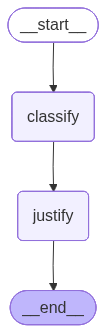

In [14]:
from IPython.display import Image, display
from classifier.graph import create_graph
from classifier.justifiers import LinearJustifier

# Grafo LangGraph (classificação + justificativa)
# Por padrão usamos o justificador linear (determinístico, sem LLM).
linear_justifier = LinearJustifier(
    ml_classifier.classifier.coef_,
    ml_classifier.classifier.classes_,
    features,
)

pipeline = create_graph(
    classifier=ml_classifier,
    justifier=linear_justifier,
)

# Visualizar a estrutura do grafo LangGraph
display(Image(pipeline.get_graph().draw_mermaid_png()))

In [15]:
from classifier.graph import run_pipeline

# Gerar justificativa usando o pipeline completo
details_graph = run_pipeline(pipeline, ticket=query)

print(f'Classe real: {true_class}')
print(f'Classe predita (ML): {details_graph.predicted_class}')
print(f'Justificativa: {details_graph.result.justificativa}')
if details_graph.reasoning:
    print('\nReasoning:')
    print(details_graph.reasoning)
print(f'\nCorreto: {details_graph.predicted_class == true_class}')

Classe real: HR Support
Classe predita (ML): HR Support
Justificativa: O ticket foi classificado como 'HR Support' por mencionar 'annual', 'leave', 'annual leave', 'balance', que são termos comumente associados a essa categoria.

Correto: True


## 5. Avaliação do Classificador

Avaliamos o desempenho do classificador escolhido (**TF-IDF + LinearSVC**) no conjunto de **validação balanceado**
(200 tickets, 25 por classe).

### Métricas utilizadas

- **Accuracy:** proporção de classificações corretas
- **F1 Macro:** média não-ponderada do F1 por classe (trata todas as classes igualmente)
- **Cohen's Kappa:** concordância além do acaso
- **MCC (Matthews Correlation Coefficient):** métrica robusta para classificação multiclasse
- **Confusion Matrix:** visualiza erros de classificação entre classes

### Sobre falhas na justificativa (LLM)

A LLM é usada **apenas** para gerar a **justificativa** (JSON). Quando há JSON inválido ou erro de API,
registramos o erro e seguimos a execução.

Nesta execução, **não houve erros de justificativa**, então as métricas abaixo refletem os **200 tickets**.


In [16]:
from classifier.metrics import evaluate, print_report, plot_confusion_matrix, plot_per_class_metrics
from classifier.runner import classify_batch
from classifier.classifiers import TfidfClassifier
from classifier.config import RANDOM_STATE

In [17]:
from classifier.graph import create_graph
from classifier.metrics import evaluate, print_report, plot_confusion_matrix, plot_per_class_metrics
from classifier.runner import classify_batch
from classifier.classifiers import TfidfClassifier
from classifier.config import RANDOM_STATE
from classifier.justifiers import LinearJustifier

# Treinar o classificador escolhido (TF-IDF + LinearSVC)
ml_classifier = TfidfClassifier.linear_svc(random_state=RANDOM_STATE)
ml_classifier.fit(train_df)

# Justificador linear (padrão)
linear_justifier = LinearJustifier(
    ml_classifier.classifier.coef_,
    ml_classifier.classifier.classes_,
    ml_classifier.features,
)

# Pipeline completo: classificação + justificativa
pipeline = create_graph(
    classifier=ml_classifier,
    justifier=linear_justifier,
)

# Gerar justificativas (classe vem do ML)
results, classification_errors, total_tokens = classify_batch(
    test_df=validation_df,
    pipeline=pipeline,
    show_progress=True,
)

# Extrair y_true e y_pred para métricas
y_true = [r["true_class"] for r in results]
y_pred = [r["predicted_class"] for r in results]

print(f"\nClassificação concluída!")
print(f"Classificados com sucesso: {len(results)}")
if classification_errors:
    print(f"Erros de justificativa: {len(classification_errors)}")

print(f"\n{'='*60}")
print("TOKEN USAGE SUMMARY")
print(f"{'='*60}")
print(f"Prompt tokens:     {total_tokens.prompt_tokens:,}")
print(f"Completion tokens: {total_tokens.completion_tokens:,}")
print(f"Total tokens:      {total_tokens.total_tokens:,}")


Justifying: 100%|██████████| 200/200 [00:00<00:00, 285.42it/s, just=linear, ok=1, pred=Storage]              


Classificação concluída!
Classificados com sucesso: 200

TOKEN USAGE SUMMARY
Prompt tokens:     0
Completion tokens: 0
Total tokens:      0


In [18]:
# Calcular métricas
metrics = evaluate(y_true, y_pred, classes)
print_report(metrics, classes)

RELATÓRIO DE AVALIAÇÃO

Accuracy:      0.8400
F1 Macro:      0.8395
F1 Weighted:   0.8395
Cohen's Kappa: 0.8171
MCC:           0.8196

------------------------------------------------------------
Classification Report:
------------------------------------------------------------
                       precision    recall  f1-score   support

               Access       0.86      1.00      0.93        25
Administrative rights       0.94      0.60      0.73        25
           HR Support       0.68      0.92      0.78        25
             Hardware       0.72      0.84      0.78        25
     Internal Project       0.96      0.88      0.92        25
        Miscellaneous       0.87      0.80      0.83        25
             Purchase       0.95      0.84      0.89        25
              Storage       0.88      0.84      0.86        25

             accuracy                           0.84       200
            macro avg       0.86      0.84      0.84       200
         weighted avg    

### Interpretação das Métricas Gerais

Os resultados no conjunto de validação indicam um classificador com **boa performance**:

| Métrica | Valor | Interpretação |
|---------|-------|---------------|
| **Accuracy** | **84.0%** | 168/200 tickets classificados corretamente |
| **F1 Macro** | **83.95%** | performance equilibrada entre as classes |
| **Cohen's Kappa** | **0.817** | concordância **alta** além do acaso |
| **MCC** | **0.820** | métrica robusta e consistente para multiclasse |

**Destaques por classe:**
- **Access:** recall **1.00** e F1 **0.93** (classe bem separada)
- **Internal Project:** precision **0.96** e F1 **0.92**
- **Purchase:** precision **0.95** e F1 **0.89**

**Pontos de atenção:**
- **Administrative rights** é a classe mais difícil (F1 **0.73**, recall **0.60**) — muitos tickets “vazam” para classes próximas
- **HR Support** tem recall alto (**0.92**), mas precision menor (**0.68**) — tende a absorver falsos positivos


### Métricas por Classe

O gráfico abaixo mostra precision, recall e F1-score para cada classe, facilitando a identificação visual de quais classes têm melhor/pior desempenho.

In [19]:
# Gráfico de métricas por classe
plot_per_class_metrics(y_true, y_pred, classes, title="Precision, Recall e F1-Score por Classe")

In [20]:
# Visualizar confusion matrix
plot_confusion_matrix(metrics["confusion_matrix"], classes, title="Confusion Matrix - TF-IDF + LinearSVC")

### Análise da Matriz de Confusão

A matriz de confusão normalizada ajuda a entender **quais classes se confundem**.

**Principais confusões (real → predito):**

| Confusão | Ocorrências | Observação |
|----------|-------------|------------|
| Administrative rights → HR Support | 3 | tickets com termos genéricos de “suporte”/“ajuda” podem cair em HR Support |
| Administrative rights → Hardware | 3 | “upgrade/update/performance” aparece nas duas classes |
| Storage → Access | 3 | tickets de storage costumam mencionar “access/permission” |
| Hardware → HR Support | 2 | descrição vaga pode soar como pedido de suporte geral |
| Internal Project → HR Support | 2 | códigos/projetos pouco explícitos no texto |

**Leitura rápida:**
- O gargalo principal segue sendo **Administrative rights** (recall **0.60**).
- **HR Support** aparece como “classe absorvedora” (recall alto, precision menor), o que é consistente com as confusões acima.


### Confusion Matrix Normalizada

A versão normalizada mostra percentagens em vez de contagens absolutas, facilitando a identificação de taxas de erro por classe.

In [21]:
# Confusion matrix normalizada (percentagens)
plot_confusion_matrix(
    metrics["confusion_matrix"], 
    classes, 
    title="Confusion Matrix - Normalizada por True Label",
    normalize=True
)

### Análise de Erros

Na avaliação podemos observar dois tipos de situações:

1. **Erros de classificação (ML):** a classe predita pelo **TF-IDF + LinearSVC** difere da classe real.
2. **Falhas de geração de justificativa (apenas no modo LLM):** a LLM pode falhar (timeout/API/JSON inválido). No modo **linear** (padrão), essa categoria não ocorre.

Abaixo analisamos os **erros de classificação** para entender padrões de confusão entre classes.


In [22]:
# Filtrar erros
errors = [r for r in results if not r["correct"]]
print(f"Total de erros: {len(errors)} de {len(results)} ({100 * len(errors) / len(results):.1f}%)\n")

# Mostrar alguns exemplos de erros
print("=" * 80)
print("EXEMPLOS DE ERROS DE CLASSIFICAÇÃO")
print("=" * 80)

for i, error in enumerate(errors[:5], 1):
    print(f"\n--- Erro {i} ---")
    print(f"Classe real:     {error['true_class']}")
    print(f"Classe predita:  {error['predicted_class']}")
    print(f"Justificativa:   {error['justification']}")
    print(f"Ticket:          {error['ticket'][:200]}...")

Total de erros: 32 de 200 (16.0%)

EXEMPLOS DE ERROS DE CLASSIFICAÇÃO

--- Erro 1 ---
Classe real:     Administrative rights
Classe predita:  HR Support
Justificativa:   O ticket foi classificado como 'HR Support' por mencionar 'to', 'set', 'and', 'xerox printers', que são termos comumente associados a essa categoria.
Ticket:          set up two xerox printers to scan and set up two xerox printers...

--- Erro 2 ---
Classe real:     Administrative rights
Classe predita:  Storage
Justificativa:   O ticket foi classificado como 'Storage' por mencionar 'folder', 'write', 'full', 'icon', que são termos comumente associados a essa categoria.
Ticket:          unable to re install some applications dearest have unusual problem xmas gift for you unable re install some applications be related icon images desktop disappeared trying re install reader error temp...

--- Erro 3 ---
Classe real:     Administrative rights
Classe predita:  HR Support
Justificativa:   O ticket foi classificado como 'HR

### Padrões nos Erros de Classificação

Com **32 erros (16.0%)** no total, os padrões mais recorrentes foram:

**1) Administrative rights → HR Support / Hardware (3 + 3 erros)**
É a classe mais difícil (recall 0.60). Muitos tickets descrevem “problema no computador” ou “preciso de ajuda”,
sem explicitar que o problema é **permissão**/direito administrativo.

**2) Storage → Access (3 erros)**
Tickets de storage frequentemente falam em “acesso”/“permission”, o que aproxima o vocabulário de Access.

**3) Outras confusões menores (2 ocorrências)**
- Hardware → HR Support
- Internal Project → HR Support
- Miscellaneous → HR Support / Hardware

**Insight:**
Boa parte dos erros acontece em zonas onde o texto do ticket é **curto** ou **genérico** e não traz termos distintivos.
Nesses casos, tanto o classificador quanto a recuperação de evidências tendem a oscilar para classes mais “amplas”.


In [23]:
# Distribuição de erros por classe
from collections import Counter

print("Distribuição de erros por classe real:")
error_by_true = Counter(e["true_class"] for e in errors)
for cls, count in sorted(error_by_true.items(), key=lambda x: -x[1]):
    print(f"  {cls}: {count} erros")

print("\nConfusões mais comuns (real → predito):")
confusion_pairs = Counter((e["true_class"], e["predicted_class"]) for e in errors)
for (true, pred), count in confusion_pairs.most_common(10):
    print(f"  {true} → {pred}: {count}x")

Distribuição de erros por classe real:
  Administrative rights: 10 erros
  Miscellaneous: 5 erros
  Hardware: 4 erros
  Purchase: 4 erros
  Storage: 4 erros
  Internal Project: 3 erros
  HR Support: 2 erros

Confusões mais comuns (real → predito):
  Administrative rights → HR Support: 3x
  Administrative rights → Hardware: 3x
  Storage → Access: 3x
  Administrative rights → Storage: 2x
  Hardware → HR Support: 2x
  Internal Project → HR Support: 2x
  Miscellaneous → HR Support: 2x
  Miscellaneous → Hardware: 2x
  Administrative rights → Miscellaneous: 1x
  Administrative rights → Access: 1x


### Similaridade do Contexto Recuperado (RAG) e Dificuldade do Ticket

Embora a **classificação** seja feita pelo modelo **TF-IDF + LinearSVC**, ainda usamos embeddings para recuperar
K tickets similares que servem como **evidência** na justificativa.

Abaixo, comparamos o score médio de similaridade dos tickets recuperados para exemplos **corretos** vs **incorretos**:

| Predições | Similaridade Média | Similaridade Mediana |
|-----------|-------------------|---------------------|
| **Corretas** | 0.763 | 0.758 |
| **Incorretas** | 0.647 | 0.649 |

**Interpretação:** tickets que o classificador erra tendem, em média, a ter **evidências menos próximas** no espaço de embeddings.
Isso é um sinal de que eles são menos “típicos”/mais ambíguos no dataset, o que pode afetar tanto a classificação quanto
a qualidade da justificativa baseada em evidência.


### Distribuição de Erros por Classe

Visualização gráfica dos erros por classe real, facilitando a identificação de quais classes são mais difíceis de classificar corretamente.

In [24]:
import plotly.express as px

# Gráfico de erros por classe
if errors:
    error_data = [{"Classe": cls, "Erros": count} for cls, count in error_by_true.items()]
    fig = px.bar(
        error_data, 
        x="Erros", 
        y="Classe", 
        orientation="h",
        title="Erros por Classe Real",
        color="Erros",
        color_continuous_scale="Reds"
    )
    fig.update_layout(height=350, showlegend=False)
    fig.show()
else:
    print("Nenhum erro de classificação para exibir!")

### Análise de Similaridade por Classe em Predições Erradas

Para cada ticket **mal classificado**, comparamos a similaridade do texto com exemplos da:
- **classe predita** (a escolhida pelo classificador)
- **classe real** (label do dataset)

Isso ajuda a entender se, no espaço de embeddings, o ticket está mais próximo da classe predita do que da real
(um indicativo de **ambiguidade do dataset** e de que evidência o RAG tende a trazer para justificar a decisão).


In [25]:
import pandas as pd

# Análise de similaridade por classe para predições erradas
if errors:
    # Para cada erro, calcular similaridade com classe predita e classe real
    similarity_data = []

    for error in errors:
        ticket_text = error['ticket']
        pred_class = error['predicted_class']
        true_class = error['true_class']

        # Similaridade com classe predita
        pred_sim = retriever.compute_class_similarity(ticket_text, pred_class, k=5)
        # Similaridade com classe real
        true_sim = retriever.compute_class_similarity(ticket_text, true_class, k=5)

        similarity_data.append({
            'ticket': ticket_text[:100] + '...',
            'pred_class': pred_class,
            'true_class': true_class,
            'similarity_pred': pred_sim['mean_score'],
            'similarity_true': true_sim['mean_score'],
            'difference': pred_sim['mean_score'] - true_sim['mean_score'],
        })

    sim_df = pd.DataFrame(similarity_data)

    # Visualização: Box plot comparando as duas similaridades
    fig = go.Figure()
    fig.add_trace(go.Box(
        y=sim_df['similarity_pred'],
        name='Classe Predita',
        marker_color='#d62728'
    ))
    fig.add_trace(go.Box(
        y=sim_df['similarity_true'],
        name='Classe Real',
        marker_color='#2ca02c'
    ))

    fig.update_layout(
        title='Similaridade por Classe em Predições Erradas',
        yaxis_title='Score de Similaridade (média top-K)',
        height=400
    )
    fig.show()

    # Estatísticas
    print(f"Similaridade com classe predita: média={sim_df['similarity_pred'].mean():.3f}, "
          f"mediana={sim_df['similarity_pred'].median():.3f}")
    print(f"Similaridade com classe real:   média={sim_df['similarity_true'].mean():.3f}, "
          f"mediana={sim_df['similarity_true'].median():.3f}")

    # Análise: Quantos erros têm maior similaridade com a predita?
    higher_pred_sim = (sim_df['similarity_pred'] > sim_df['similarity_true']).sum()
    print(f"\nErros com maior similaridade à classe predita: {higher_pred_sim}/{len(errors)} "
          f"({100*higher_pred_sim/len(errors):.1f}%)")
else:
    print("Nenhum erro de classificação para análise de similaridade.")

Similaridade com classe predita: média=0.606, mediana=0.606
Similaridade com classe real:   média=0.587, mediana=0.604

Erros com maior similaridade à classe predita: 17/32 (53.1%)


## 6. Síntese dos Resultados com LLM (opcional)

Opcionalmente, podemos usar uma LLM para sintetizar os resultados desta execução em um texto técnico.
Essa etapa **não participa da classificação**: ela apenas resume métricas, padrões de erro e trade-offs.

Ela recebe:
- métricas globais e por classe
- matriz de confusão e principais confusões
- amostras de erros (até 20), com justificativa e tickets similares recuperados como evidência
- configuração da execução (k, modelos e random_state)

A seguir, geramos a síntese com os dados desta execução.


In [26]:
from classifier.conclusion import (
    build_conclusion_payload,
    build_conclusion_system_prompt,
    build_conclusion_user_prompt,
)
from classifier.config import EMBEDDING_MODEL, K_SIMILAR, RANDOM_STATE
from classifier.llm import ConclusionError, LlmClient

llm_client = None
llm_model = None
try:
    llm_client = LlmClient()
    llm_model = llm_client.model
except ValueError:
    print("LLM não configurada; pulando geração da conclusão.")

payload = build_conclusion_payload(
    dataset="dataset.csv",
    classes=classes,
    test_size=len(validation_df),
    k_similar=K_SIMILAR,
    embedding_model=EMBEDDING_MODEL,
    llm_model=llm_model,
    random_state=RANDOM_STATE,
    classifications=results,
    errors=classification_errors,
    metrics=metrics,
    token_usage=total_tokens,
    max_misclassified=20,
)

if llm_client:
    system_prompt = build_conclusion_system_prompt()
    user_prompt = build_conclusion_user_prompt(payload)

    try:
        conclusion_text, conclusion_usage = llm_client.generate_conclusion(
            system_prompt=system_prompt,
            user_prompt=user_prompt,
        )
        print(conclusion_text)
        print(f"\nTokens usados (conclusão): {conclusion_usage.total_tokens:,}")
    except ConclusionError as exc:
        print(f"Falha ao gerar conclusão: {exc}")


This JSON data represents the results of a classification analysis on a set of tickets. Let's break down what each part means:

**Overall Structure:**

* **`data`**: This is the main object containing all the information about the ticket classifications. 
    * **`miscellaneous`**:  A list of miscellaneous tickets, likely related to general issues or requests.
    * **`internal_project`**: A list of tickets related to internal project management and development.
    * **`hardware`**: A list of tickets related to hardware-related issues. 
    * **`purchase`**: A list of tickets related to purchase and procurement.
    * **`storage`**: A list of tickets related to storage and file management.
    * **`hr_support`**: A list of tickets related to HR support, including employee onboarding, benefits, payroll, etc. 

**Key Data Points:**

* **`id`**:  A unique identifier for each ticket (e.g., "1", "2").
* **`ticket_text`**: The full text of the ticket description. This is where you'd find th

## 7. Considerações Finais

- O classificador **TF-IDF + LinearSVC** apresentou **84% de accuracy** e **~84% de F1 macro** na validação balanceada,
  sendo uma escolha forte por combinar **boa performance** e **baixo custo/latência**.
- Para justificativas, mantemos como padrão o método **linear** (determinístico e sem dependência de LLM). Quando necessário, o modo **LLM + RAG** pode ser ativado para produzir justificativas mais naturais, ao custo de tokens/latência.
- Os principais erros concentram-se em classes semanticamente próximas (padrões de confusão), sugerindo pontos de melhoria com features e/ou ajustes no retriever.
